# Real or Fake - The Analysis of Real News and Fake News

### Zhaoyang Chen

## Introduction

The latest hot topic in the news is fake news and many are wondering what social scientists can do to detect it and stymie its viral spread. Fake news is a form of news consisting of deliberate disinformation or hoaxes spread via traditional news media (print and broadcast) or online social media. Some fake news are deceptive, making them indistinguishable from real news. In May 9, 2018, President Donald Trump tweeted that "The Fake News is working overtime. Just reported that, despite the tremendous success we are having with the economy & all things else, 91% of the Network News about me is negative (Fake). Why do we work so hard in working with the media when it is corrupt? Take away credentials?", which indicates the power of fake news. In the final project, I will use the real & fake news data in [kaggle](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset), provided by Clément Bisaillon, to conduct a deep analysis of real and fake news. Basically, I want to explore the difference between real news and fake news. Also, I would like to build a simple fake news detector, that is, a basic classifier that can detect most fake news. Finally, a fake news generator can be constructed with deep learning methods.

In section 2, I will conduct a data pre-processing on the news dataset and I will briefly explore the dataset in section 3. In section 4, I will build a classification model on fake and real news. I will also construct a fake news generator in section 5. Conclusion and discussion are included in section 6.

## Data Pre-processing

### Load Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup

import re,string,unicodedata

from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import silhouette_score, silhouette_samples, classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve

from string import punctuation

from nltk import pos_tag
from nltk.corpus import wordnet
from textblob import TextBlob

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

[nltk_data] Downloading package stopwords to /Users/holly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/holly/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


### Load Data

In [30]:
real = pd.read_csv('./fake-and-real-news-dataset/true.csv')
fake = pd.read_csv('./fake-and-real-news-dataset/fake.csv')

real['category'] = 1
fake['category'] = 0

df = pd.concat([real,fake]) #Merging the 2 datasets

In [11]:
real.count()

title       21417
text        21417
subject     21417
date        21417
category    21417
dtype: int64

In [12]:
fake.count()

title       23481
text        23481
subject     23481
date        23481
category    23481
dtype: int64

Text(0.5, 1.0, 'Category Distribution')

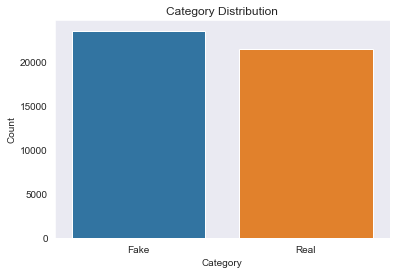

In [3]:
sns.set_style("dark")
sns.countplot(df.category)
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks([1,0],['Real','Fake'])
plt.title('Category Distribution')

Text(0.5, 1.0, 'Subject Distribution')

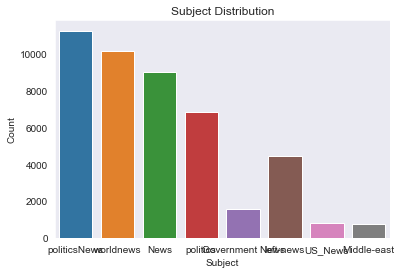

In [14]:
sns.countplot(df.subject)
plt.xlabel('Subject')
plt.ylabel('Count')
plt.title('Subject Distribution')

In [15]:
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  category  
0  December 31, 2017          1  
1  December 29, 2017          1  
2  December 31, 2017          1  
3  December 30, 2017          1  
4  December 29, 2017          1

## Exploratory Data Analysis

### Explore the Fake News

In [16]:
#Counting by Subjects 
for key,count in fake.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")
    
#Getting Total Rows
print(f"Total Records:\t{fake.shape[0]}")

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


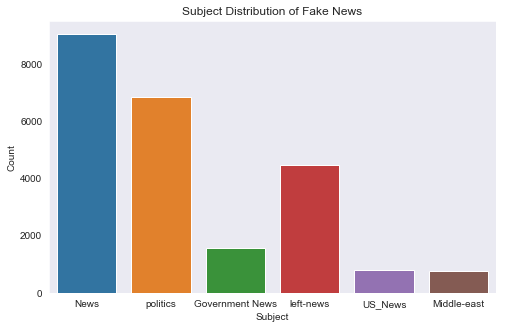

In [17]:
plt.figure(figsize=(8,5))
sns.countplot("subject", data=fake)
plt.xlabel('Subject')
plt.ylabel('Count')
plt.title('Subject Distribution of Fake News')
plt.show()

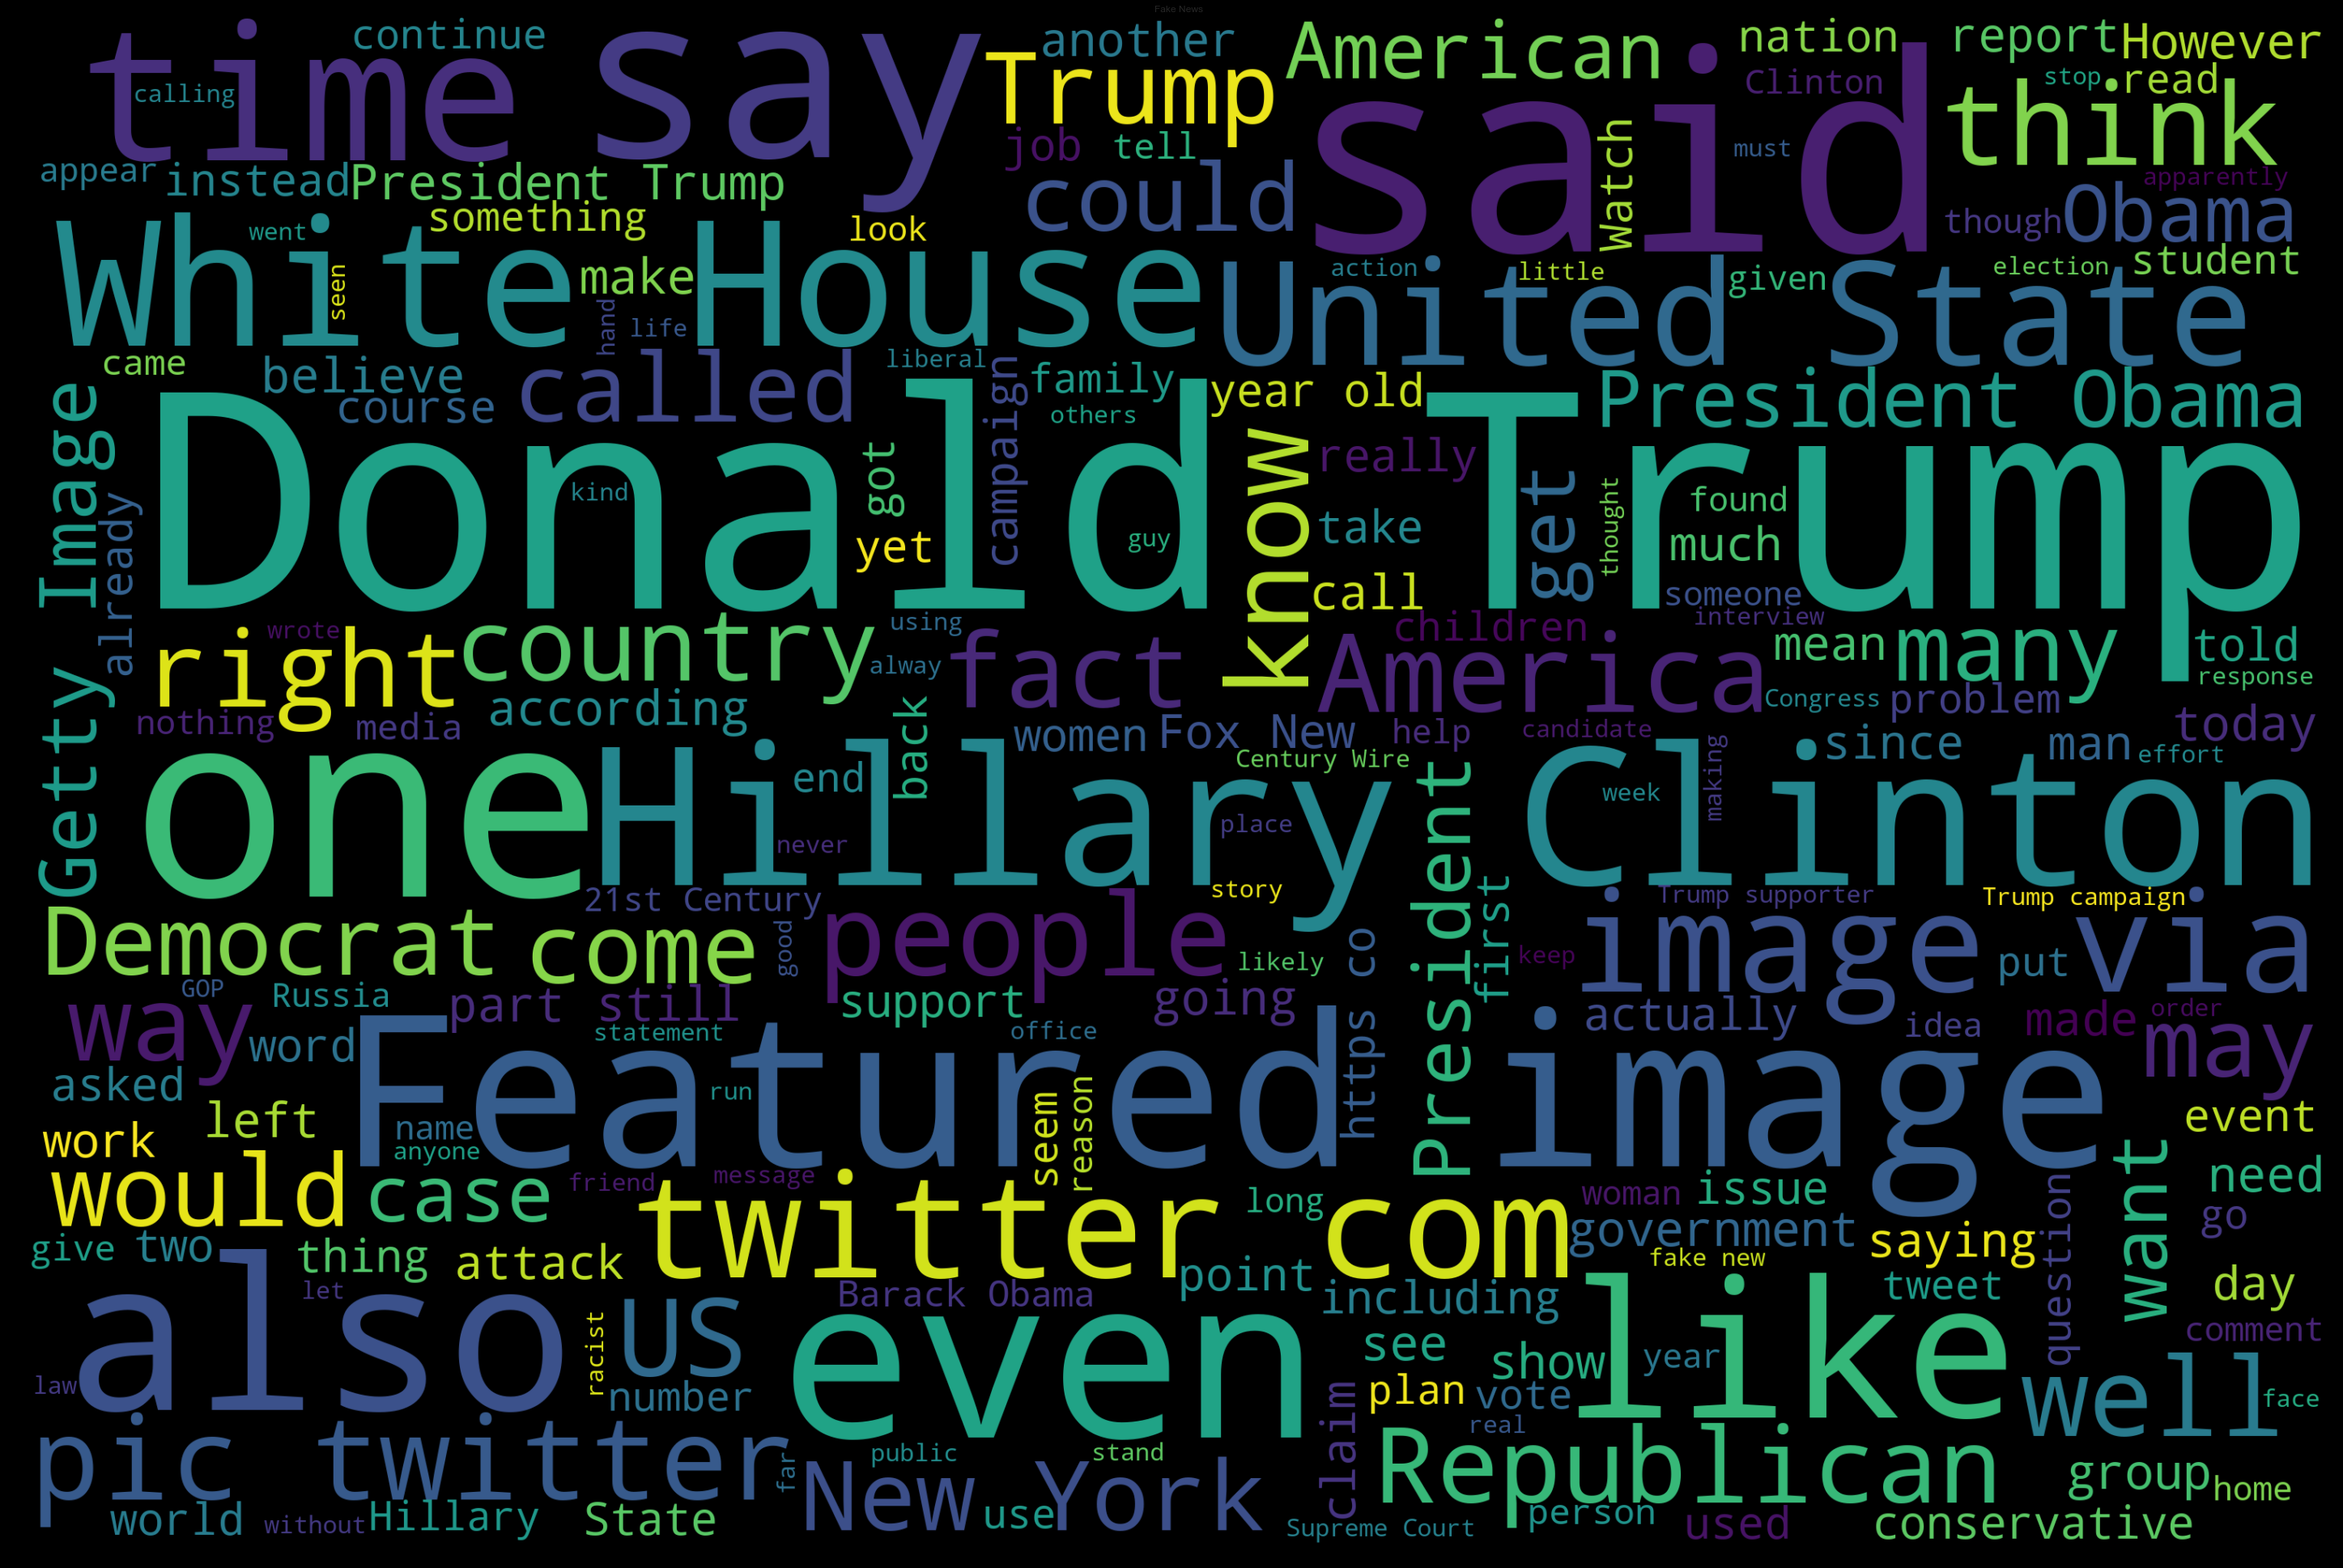

In [18]:
#Word Cloud
text = ''
for news in fake.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Fake News')
plt.show()
del text

In [19]:
real.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  category  
0  December 31, 2017          1  
1  December 29, 2017          1  
2  December 31, 2017          1  
3  December 30, 2017          1  
4  December 29, 2017          1

### Explore Real News

In [20]:
#Counting by Subjects 
for key,count in real.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")
    
#Getting Total Rows
print(f"Total Records:\t{real.shape[0]}")

politicsNews:	11272
worldnews:	10145
Total Records:	21417


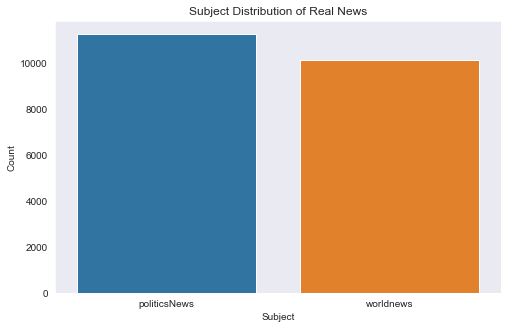

In [21]:
plt.figure(figsize=(8,5))
sns.countplot("subject", data=real)
plt.xlabel('Subject')
plt.ylabel('Count')
plt.title('Subject Distribution of Real News')
plt.show()

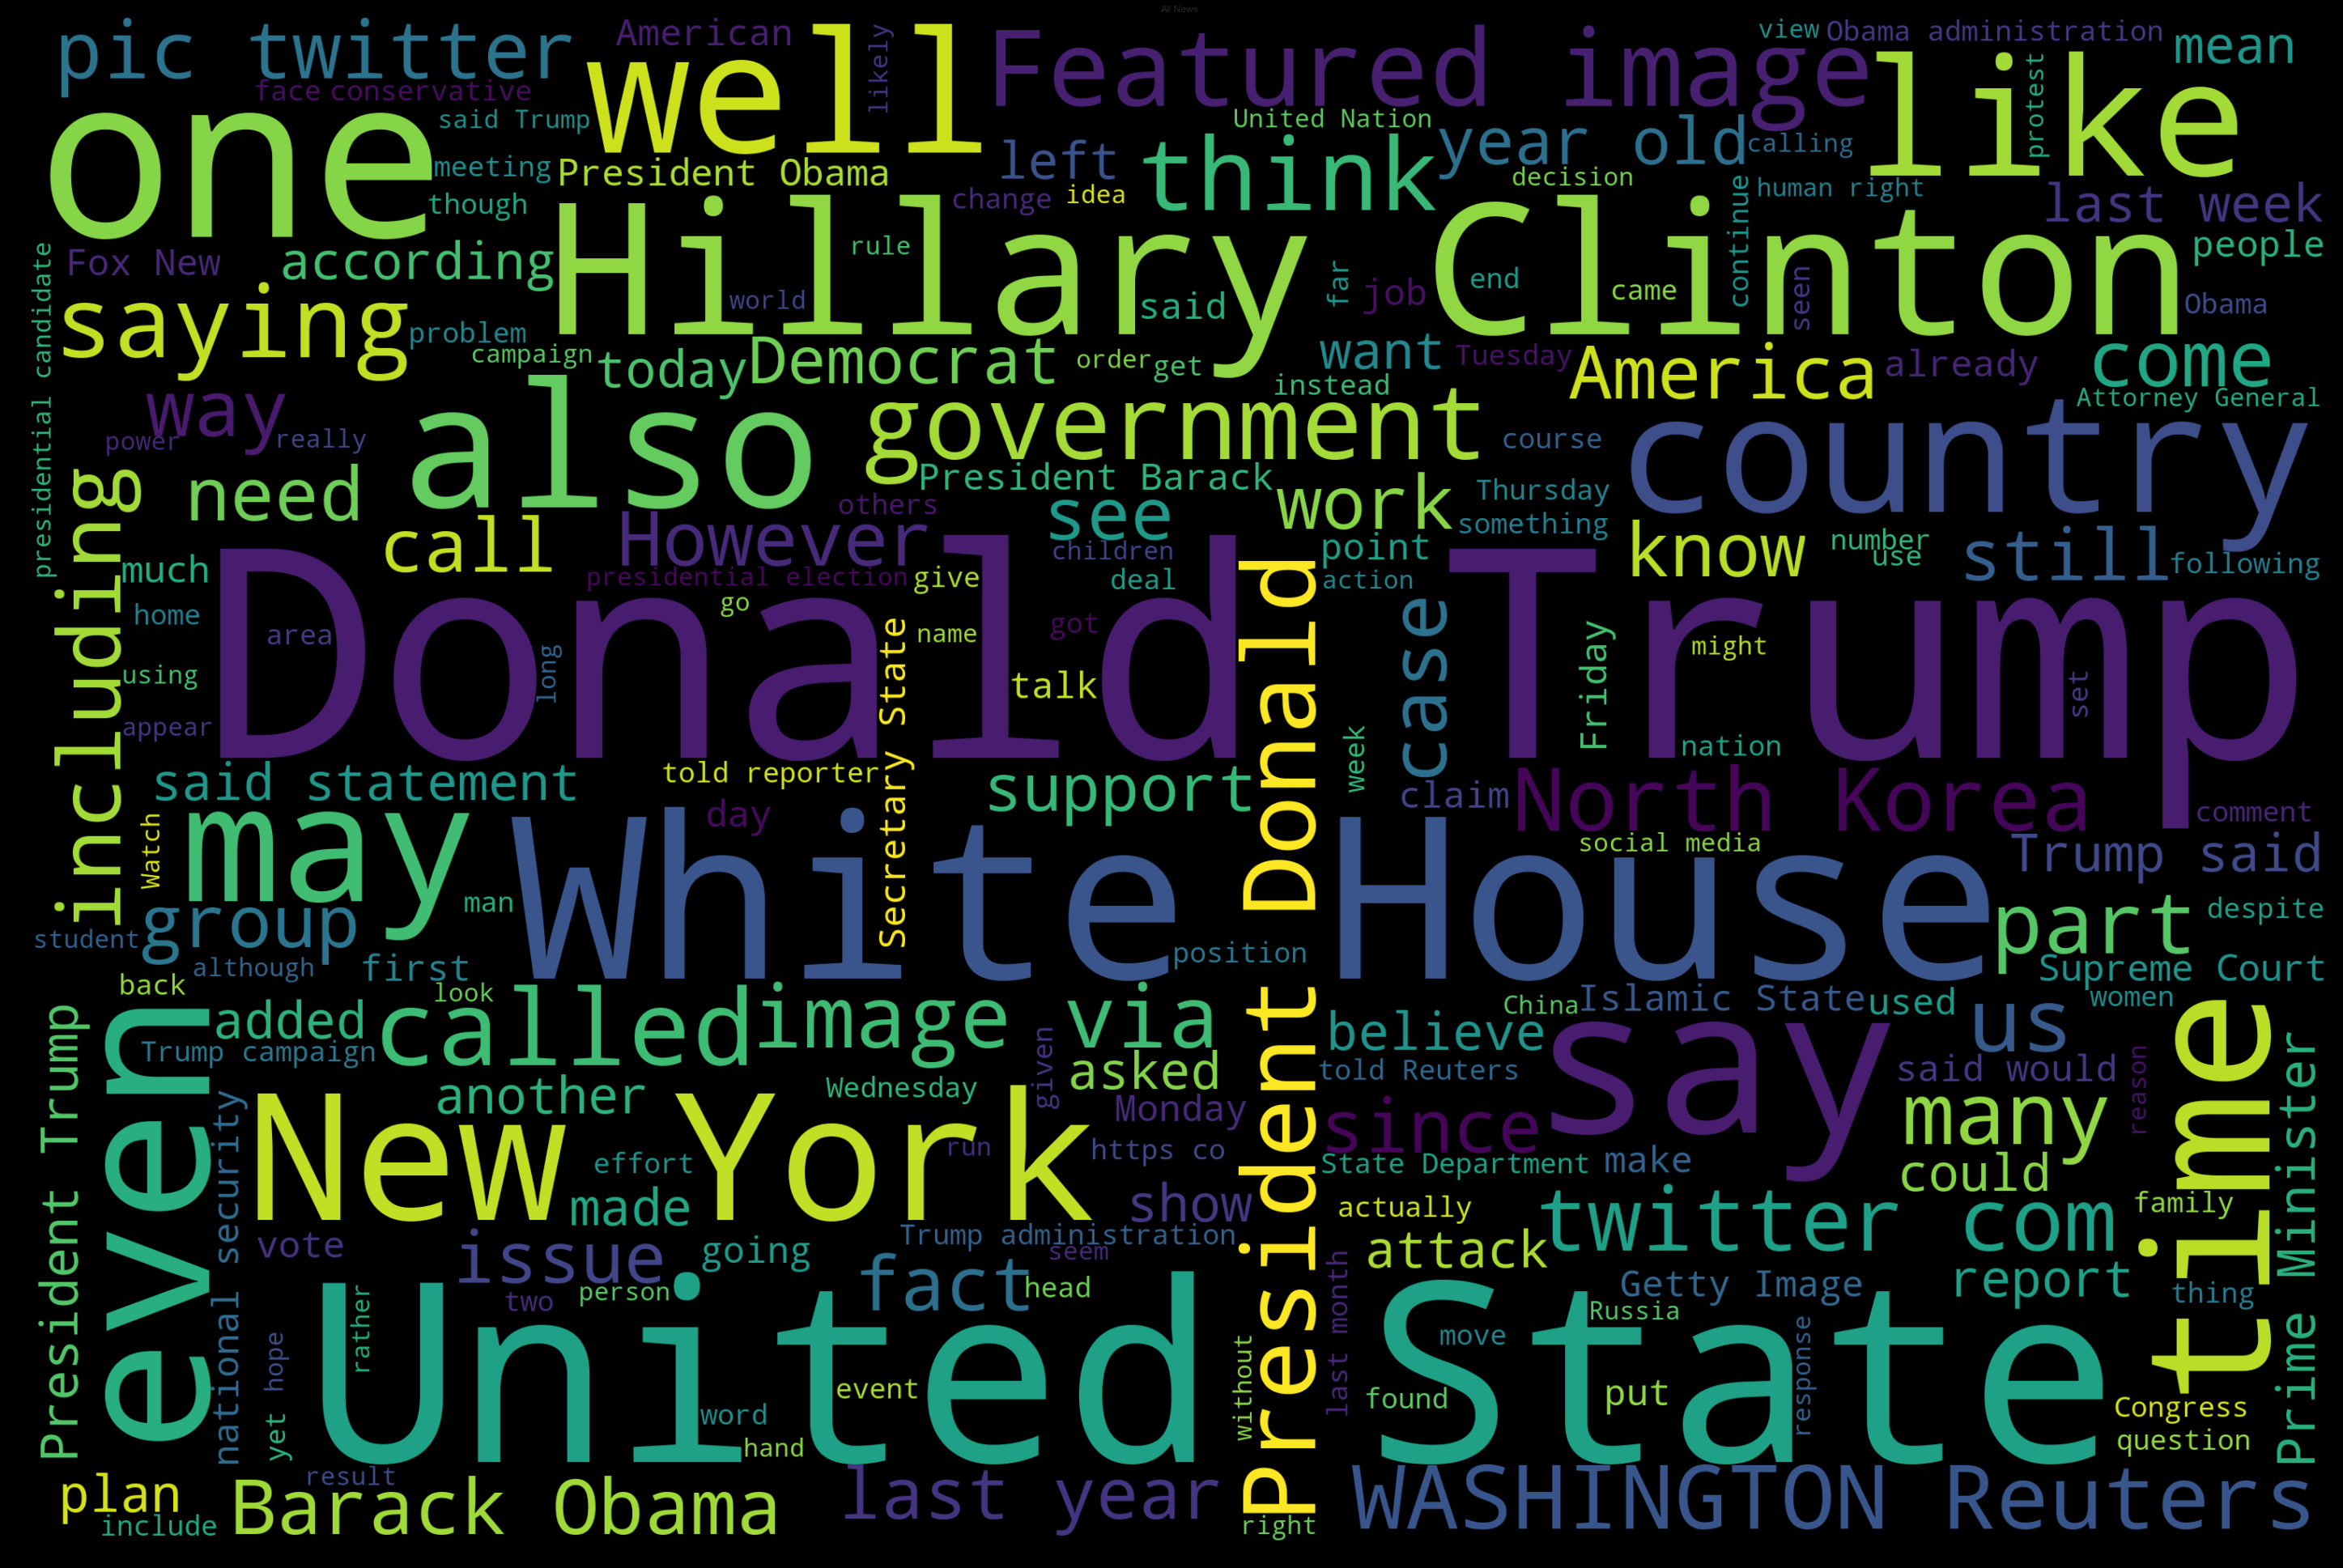

In [49]:
#Word Cloud
text = ''
for news in df.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('All News')
plt.show()
del text

In [47]:
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  category  
0  December 31, 2017          1  
1  December 29, 2017          1  
2  December 31, 2017          1  
3  December 30, 2017          1  
4  December 29, 2017          1

### Difference in Text
Real news seems to have source of publication which is not present in fake news set

Looking at the data:

- most of text contains reuters information such as "WASHINGTON (Reuters)".
- Some text are tweets from Twitter
- Few text do not contain any publication info

## Data Cleaning

Removing Reuters or Twitter Tweet information from the text

- Text can be splitted only once at " - " which is always present after mentioning source of publication, this gives us publication part and text part
- If we do not get text part, this means publication details was't given for that record
- The Twitter tweets always have same source, a long text of max 259 characters

In [4]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(real.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [5]:
#Thus we have list of indices where publisher is not mentioned
#lets check
real.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

While looking at texts that do not contain publication info such as which reuter, we noticed one thing.

**Text at index 8970 is empty.**

In [6]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(real.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [7]:
#Replace existing text column with new text
#add seperate column for publication info
real["publisher"] = publisher
real["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [8]:
# real = real.drop(8970, axis=0)
real.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0   The head of a conservative Republican faction...  politicsNews   
1   Transgender people will be allowed for the fi...  politicsNews   
2   The special counsel investigation of links be...  politicsNews   
3   Trump campaign adviser George Papadopoulos to...  politicsNews   
4   President Donald Trump called on the U.S. Pos...  politicsNews   

                 date  category                     publisher  
0  December 31, 2017          1          WASHINGTON (Reuters)  
1  December 29, 2017          1          WASHINGTON (Reuters)  
2  December 31, 2017          1          WASHINGTON (Reuters)  
3  December 30, 2017          1          WASHINGTON (Reuters)  
4  December 29, 2017          1  SEATTLE/WASHINGTON (Reuters)

In [9]:
# checking for the same in fake news
empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake.iloc[empty_fake_index].tail()

No of empty rows: 630


title text    subject  \
21816  BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...       left-news   
21826  FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...       left-news   
21827  (VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...       left-news   
21857  (VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...       left-news   
21873  (VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...       left-news   

               date  category  
21816  Apr 27, 2015         0  
21826  Apr 25, 2015         0  
21827  Apr 25, 2015         0  
21857  Apr 14, 2015         0  
21873  Apr 12, 2015         0

**630 Rows in Fake news with empty text.**

Also noticed fake news have a lot of CPATIAL-CASES. Could preserve Cases of letters, but as we are using Google's pretrained word2vec vectors later on, which haswell-formed lower cases word. We will contert to lower case.

The text for these rows seems to be present in title itself. Lets merge title and text to solve these cases.

### Processing Text

In [10]:
# Adding class Information
real["class"] = 1
fake["class"] = 0

In [11]:
#Combining Title and Text
real["text"] = real["title"] + " " + real["text"]
fake["text"] = fake["title"] + " " + fake["text"]

In [12]:
# Subject is diffrent for real and fake thus dropping it
# Aldo dropping Date, title and Publication Info of real
real = real.drop(["subject", "date","title",  "publisher"], axis=1)
fake = fake.drop(["subject", "date", "title"], axis=1)

In [13]:
#Combining both into new dataframe
data = real.append(fake, ignore_index=True)
del real, fake

In [14]:
y = data["class"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del data

## Word2Vec

In [22]:
import gensim

In [23]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [24]:
#vocab size
len(w2v_model.wv.vocab)

#We have now represented each of 122248 words by a 100dim vector.

122248

In [38]:
w2v_model.wv.most_similar('nba')

[('championship', 0.7684945464134216),
 ('cavaliers', 0.7226517200469971),
 ('spangled', 0.7181944251060486),
 ('tournament', 0.7142000198364258),
 ('grammy', 0.7055109143257141),
 ('steelers', 0.7053245306015015),
 ('coach', 0.7026687264442444),
 ('studded', 0.6914722919464111),
 ('football', 0.6883120536804199),
 ('basketball', 0.6837629675865173)]

In [39]:
w2v_model.wv.most_similar("computer")

[('computers', 0.8372820615768433),
 ('software', 0.7851327657699585),
 ('malware', 0.7786709666252136),
 ('laptop', 0.7530776858329773),
 ('servers', 0.751899003982544),
 ('electronic', 0.7401832342147827),
 ('encrypted', 0.7122709155082703),
 ('scanning', 0.7099363207817078),
 ('accessed', 0.6990166902542114),
 ('kaspersky', 0.6932798624038696)]

In [40]:
#Feeding US Presidents
w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])
#First was Bush

[('bush', 0.5111861228942871),
 ('incoming', 0.5059790015220642),
 ('hillary', 0.5034540295600891),
 ('elect', 0.49804627895355225),
 ('cruz', 0.49062734842300415),
 ('actually', 0.4738841950893402),
 ('crooked', 0.4731544852256775),
 ('somehow', 0.4637277126312256),
 ('streeter', 0.46068745851516724),
 ('course', 0.4535624384880066)]

In [84]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(X)

# X = tokenizer.texts_to_sequences(X)
# word_index = tokenizer.word_index

In [25]:
doc_vec = []
for doc in X:
    vec = np.zeros(100)
    i = 0
    for word in doc:
        i += 1
        vec += w2v_model[word]
    doc_vec.append(vec/i)

/Users/holly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


### PCA

In [26]:
doc_vec = np.vstack(doc_vec)
pca = PCA(n_components=2, svd_solver='full')
doc_vec_red = pca.fit_transform(doc_vec)

In [27]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(doc_vec)

In [28]:
label = kmeans.labels_
pc = pd.DataFrame({
    'PC1':doc_vec_red[:,0],
    'PC2':doc_vec_red[:,1]
})

Text(0.5, 1.0, 'K-Means based on Word2Vec')

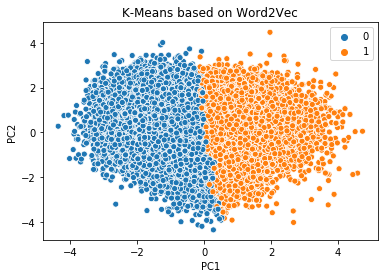

In [28]:
sns.scatterplot(x = pc.PC1, y = pc.PC2, hue = label)
plt.title('K-Means based on Word2Vec')

Text(0.5, 1.0, 'Original Data based on Word2Vec')

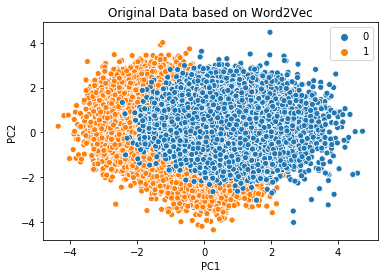

In [27]:
sns.scatterplot(x = pc.PC1, y = pc.PC2, hue = y)
plt.title('Original Data based on Word2Vec')

## TF-IDF

In [16]:
texts = [' '.join(sublist) for sublist in X]
df = pd.DataFrame({'Text':texts, 'Label':y})
df_sam = df.sample(n = 1000)

tfidf = TfidfVectorizer(min_df=2,max_df=0.5,ngram_range=(1,2))
features = tfidf.fit_transform(list(df_sam['Text']))

In [17]:
tfidf_df = pd.DataFrame(features.todense())

In [18]:
pca = PCA(n_components=10, svd_solver='full')
pca.fit(tfidf_df)
tfidf_df_red = pca.fit_transform(tfidf_df)

kmeans = KMeans(n_clusters=2, random_state=0).fit(tfidf_df_red)

In [24]:
label = kmeans.labels_
pc = pd.DataFrame({
    'PC1':tfidf_df_red[:,0],
    'PC2':tfidf_df_red[:,1],
    'y': df_sam['Label']
})

Text(0.5, 1.0, 'K-Means based on TF-IDF')

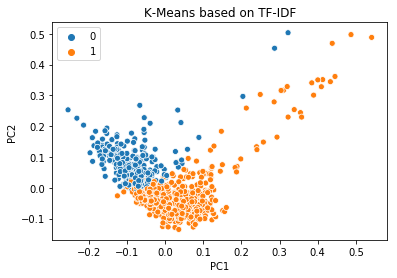

In [20]:
sns.scatterplot(x = pc.PC1, y = pc.PC2, hue = label)
plt.title('K-Means based on TF-IDF')

Text(0.5, 1.0, 'Original Data based on TF-IDF')

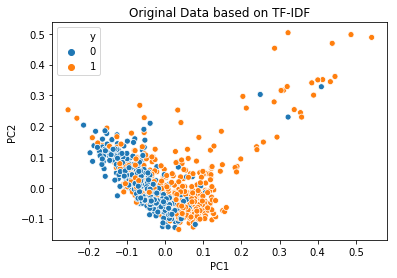

In [25]:
sns.scatterplot(x = pc.PC1, y = pc.PC2, hue = pc.y)
plt.title('Original Data based on TF-IDF')

## Sentimental Analysis

In [15]:
# function to calculate sentiment score
def senti(x):
    return TextBlob(x).sentiment

text = [' '.join(item) for item in X]
score = list(map(senti, text))
score_df = pd.DataFrame({'Score':score, 'Label':y})

In [16]:
score_df_real = score_df[score_df.Label == 1]['Score']
score_df_fake = score_df[score_df.Label == 0]['Score']

polar_fake = [score[0] for score in score_df_fake]
sub_fake = [score[1] for score in score_df_fake]
polar_real = [score[0] for score in score_df_real]
sub_real = [score[1] for score in score_df_real]

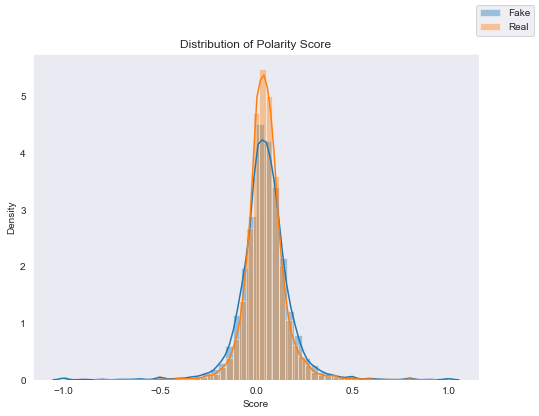

In [17]:
fig = plt.figure(figsize=(8,6))
sns.distplot(polar_fake)
sns.distplot(polar_real)
plt.title('Distribution of Polarity Score')
plt.xlabel('Score')
plt.ylabel('Density')
fig.legend(labels = ['Fake','Real'])

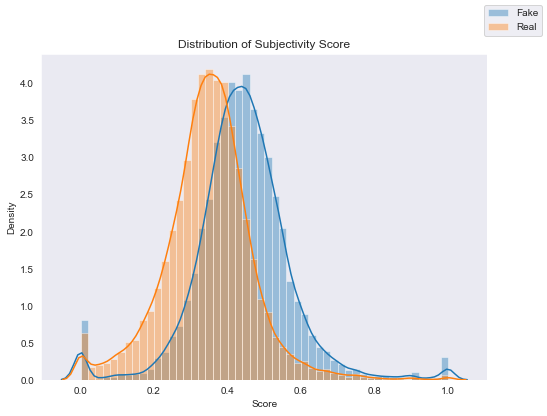

In [18]:
fig = plt.figure(figsize=(8,6))
sns.distplot(sub_fake)
sns.distplot(sub_real)
plt.title('Distribution of Subjectivity Score')
plt.xlabel('Score')
plt.ylabel('Density')
fig.legend(labels = ['Fake','Real'])

In [19]:
print(np.mean(polar_fake))
print(np.mean(polar_real))

0.04551036032951523
0.046601117896881955


In [20]:
print(np.mean(sub_fake))
print(np.mean(sub_real))

0.44144625934136633
0.34744450664061355


## Detect Fake News

In [113]:
X = pd.DataFrame(doc_vec)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

### Logisitc Regression

In [114]:
model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)
prediction = model_logistic.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
fpr1 , tpr1, thresholds1 = roc_curve(y_test, prediction)

/Users/holly/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy: 95.36%


### Random Forest

In [116]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
prediction = model_rf.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
fpr2 , tpr2, thresholds2 = roc_curve(y_test, prediction)

/Users/holly/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy: 94.3%


### SVM

In [117]:
model_svm = LinearSVC()
model_svm.fit(X_train, y_train)
prediction = model_svm.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
fpr3 , tpr3, thresholds3 = roc_curve(y_test, prediction)

accuracy: 95.27%


/Users/holly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Naive Bayes

In [118]:
model_nb = BernoulliNB()
model_nb.fit(X_train, y_train)
prediction = model_nb.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
fpr4 , tpr4, thresholds4 = roc_curve(y_test, prediction)

accuracy: 85.24%


### GBC

In [119]:
model_gbc = GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 10,
                                                   max_depth = 5,
                                                   random_state=55)
model_gbc.fit(X_train, y_train)
prediction = model_gbc.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
fpr5 , tpr5, thresholds5 = roc_curve(y_test, prediction)

accuracy: 86.9%


### SGC

In [120]:
model_sgd = SGDClassifier()
model_sgd.fit(X_train, y_train)
prediction = model_sgd.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
fpr6 , tpr6, thresholds6 = roc_curve(y_test, prediction)

accuracy: 94.03%


/Users/holly/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


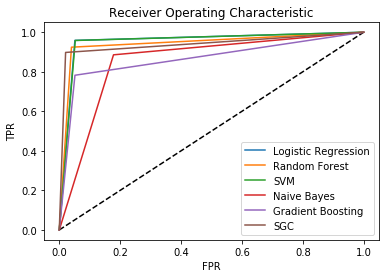

In [121]:
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Logistic Regression")
plt.plot(fpr2, tpr2, label= "Random Forest")
plt.plot(fpr3, tpr3, label= "SVM")
plt.plot(fpr4, tpr4, label= "Naive Bayes")
plt.plot(fpr5, tpr5, label= "Gradient Boosting")
plt.plot(fpr6, tpr6, label= "SGC")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

In [46]:
pd.DataFrame({'Fake':sub_fake[0:19], 'Real':sub_real[0:19]}).head(20)

Fake      Real
0   0.602972  0.403438
1   0.336737  0.300544
2   0.519968  0.311252
3   0.401613  0.267688
4   0.487121  0.356633
5   0.488889  0.337078
6   0.424479  0.499182
7   0.297243  0.562500
8   0.490680  0.357792
9   0.528655  0.680000
10  0.370677  0.403237
11  0.377311  0.380451
12  0.511071  0.352381
13  0.500000  0.353704
14  0.537836  0.499719
15  0.582183  0.405643
16  0.390030  0.279224
17  0.407341  0.486777
18  0.480522  0.322169